# Approche modale

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, linalg, integrate
from scipy.io.wavfile import write
import IPython

%matplotlib inline

## Modélisation résonateur

In [30]:
# constants
rho0 = 1.225    # air density for T = 15°C
c = 340
mu = 18.5e-6 

R = 0.014
Pabsc = np.linspace(0, 0.5, 2)
Prayon = np.ones_like(Pabsc) * R

In [31]:
def get_Z_e(f, DISPLAY=False, SCREEN=False):
    """
    Algorithme impédance rapportée 
    (dans le cas général plus de 2 éléments cônes/cylindres)
    """
    omega = 2*np.pi*f
    n_sec = len(Pabsc)  # number of sections

    PU = np.zeros((2, n_sec), dtype=complex)  # PU[0] = pressure, PU[1] = velocity

    # constants
    S_out = np.pi * Prayon[-1]**2 # Surface de sortie
    k0 = omega / c
    kv = np.sqrt(omega * rho0 / mu)     # modulus of k_v

    k = k0
    rho = rho0

    a = Prayon[-1]

    if SCREEN:
        Z_r = rho0 * c / S_out * (0.5 * (k*a)**2 + 8j * k*a / (3*np.pi))
    else:
        Z_r = rho0 * c / S_out * (0.25*(k*a)**2 + 0.6133j * k*a) # Impedance de rayonnement, zegrev 3 p.3

    # Conditions en sortie
    PU[0, -1] = 10e5        # out pressure (atmospheric)
    PU[1, -1] = PU[0, -1] / Z_r   # out speed
    

    l_list = np.sqrt((Pabsc[1:] - Pabsc[:-1])**2 + (Prayon[1:] - Prayon[:-1])**2) 

    for i in reversed(range(n_sec-1)):
        x1, x2 = Pabsc[i], Pabsc[i+1]
        R1, R2 = Prayon[i], Prayon[i+1]
        l = l_list[i]
        
        
        # Avec pertes (Zegrev4, p.13)
        r_v = kv * (R1 + R2) / 2
        k = k0 * (1 + 1.044 * np.sqrt(-2*1j)/r_v)
        rho = rho0 * (1 + 2*np.sqrt(-1j)/r_v)

        # Constante de couplage
        beta = rho * c / (np.pi * R1 * R2)

        kx1, kx2, kl = k*x1, k*x2, k*l
        cos_kl, sin_kl = np.cos(kl), np.sin(kl)

        A = cos_kl
        B = 1j * beta * sin_kl
        C = 1j / beta * sin_kl
        D = cos_kl
  
        transfer_matrix = np.array([[A, B], [C, D]])
        PU[:, i] = transfer_matrix @ PU[:, i+1]
        
    P, U = PU
    Z_e = P[0] / U[0] # Impedance d'entree

    return Z_e



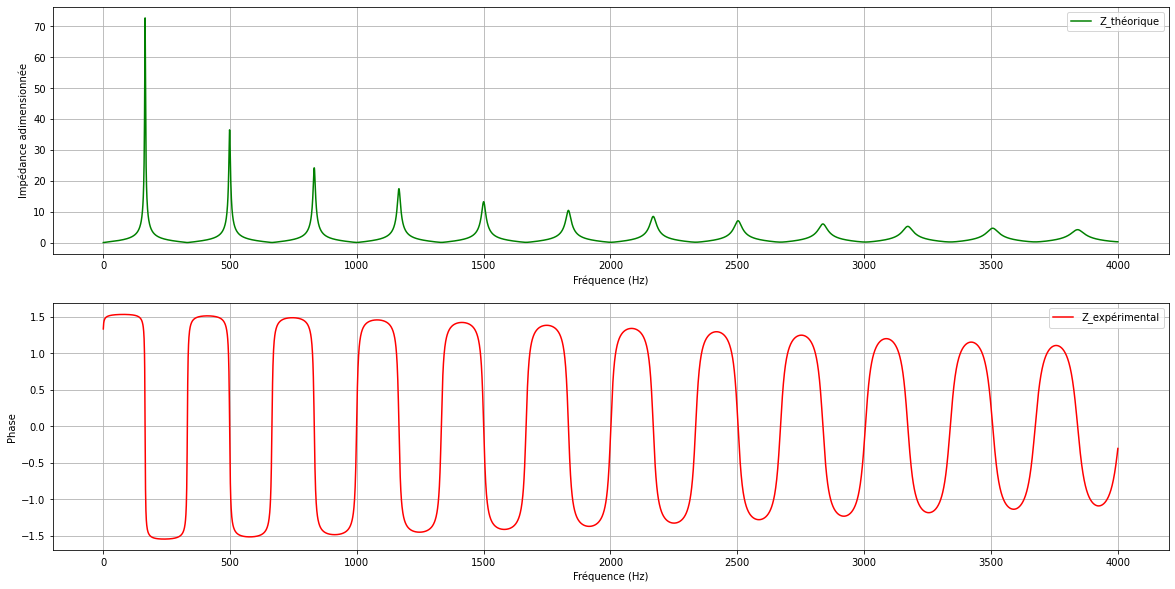

In [32]:
freq_th = np.linspace(1, 4000, 5000)
Z_th = np.zeros_like(freq_th, dtype=complex)


for i, f in enumerate(freq_th):
    Z_th[i] = get_Z_e(f, DISPLAY=True, SCREEN=False)
    
S_out = np.pi * R**2
Z_th = Z_th * S_out/(rho0*c)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))


ax1.plot(freq_th, np.abs(Z_th), 'g', label='Z_théorique')
ax1.set_xlabel('Fréquence (Hz)')
ax1.set_ylabel('Impédance adimensionnée')
ax1.legend()
ax1.grid()

ax2.plot(freq_th, np.angle(Z_th), 'r', label='Z_expérimental')
ax2.set_xlabel('Fréquence (Hz)')
ax2.set_ylabel('Phase')
ax2.legend()
ax2.grid()

plt.show()

Fréquences théoriques
[ 165.  498.  831. 1166. 1499. 1834. 2168. 2502. 2837. 3171. 3506. 3841.]


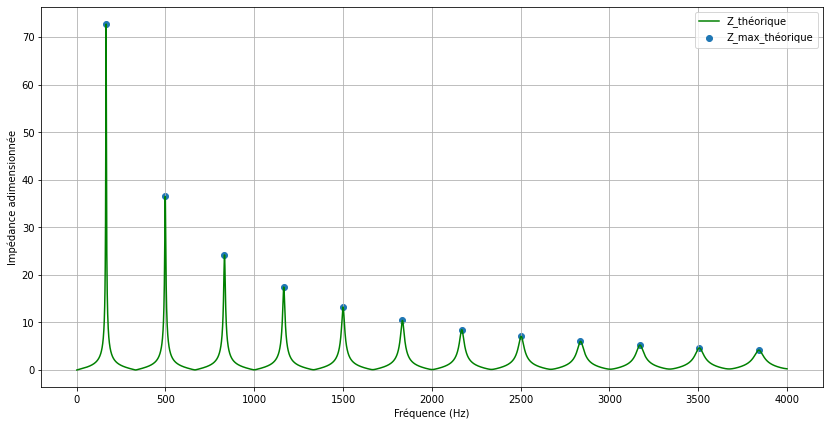

In [33]:
Fs = 8000

index_peaks_th = signal.find_peaks(np.abs(Z_th))[0]

frq_peaks_th = index_peaks_th * (Fs/2)/len(Z_th)

print("Fréquences théoriques")
print(np.round(frq_peaks_th.tolist()))

plt.figure(figsize=(14,7))
plt.plot(freq_th, np.abs(Z_th), 'g', label='Z_théorique')
plt.scatter(frq_peaks_th, np.abs(Z_th)[index_peaks_th], label="Z_max_théorique")
plt.legend()
plt.grid()
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Impédance adimensionnée')
plt.show()

In [34]:
def esprit(x, n, K, PROGRESS = False):
    """
    ESPRIT algorithm
    Compute damping and frequencies
    """
    N = len(x)
    l = N - n + 1
    
    # Matrice correlation
    x_first = x[:n]
    x_last = x[l-1:N]
    if PROGRESS : print("Computing Hankel matrix X...")
    X = linalg.hankel(x_first, x_last)
    X = np.matrix(X)
    if PROGRESS : print("Computing correlation matrix Rxx...")
    R_xx = 1/l * np.dot(X, X.H)
    
    # Espace image
    if PROGRESS : print("Computing image space...")
    l, U1 = np.linalg.eig(R_xx)
    W = U1[:,:K]
    
    # Frq et damping
    if PROGRESS : print("Computing final results...")
    W_down = W[:-1]
    W_up = W[1:]
    Phi = np.dot(np.linalg.pinv(W_down), W_up)
    eigen_Phi, _ = np.linalg.eig(Phi) # Keep only eigen values, not vectors
    damping_esprit = np.log(np.abs(eigen_Phi))
    frq_esprit = np.angle(eigen_Phi) / (2*np.pi)

    
    if PROGRESS : print()
    return damping_esprit, frq_esprit



def least_squares(x, delta, f):
    """
    Least squares method
    Compute amplitudes and phases
    """
    N = len(x)
    
    z_k = np.exp(delta) * np.exp(1j*2*np.pi*f)
    vandermonde_N = np.vander(z_k, N).T # V(t,k) = z_k^(N-t)
    vandermonde_N = np.flipud(vandermonde_N) # V(t,k) = z_k^t

    amp_cpx = np.dot(np.linalg.pinv(vandermonde_N), x)

    amp_esprit = np.abs(amp_cpx)
    phase_esprit = np.angle(amp_cpx)
    
    return amp_esprit, phase_esprit


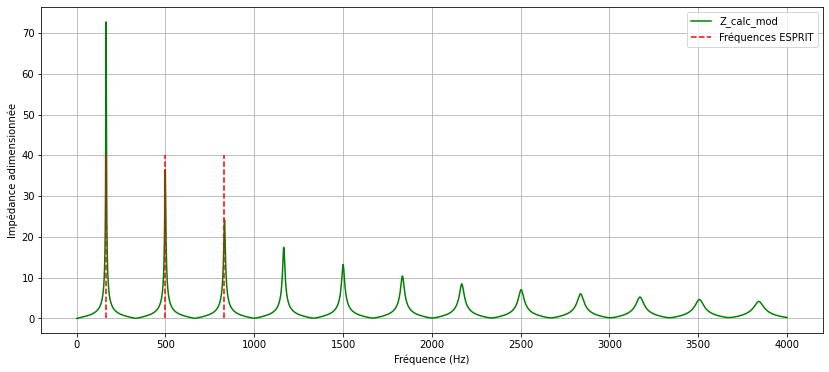

In [37]:
ifft_z = np.fft.irfft(Z_th)

damping_esprit, frq_res_esprit = esprit(ifft_z, 1500, 6)
amp_esprit, phase_esprit = least_squares(ifft_z, damping_esprit, frq_res_esprit)

frq_res_esprit_adim = frq_res_esprit.copy()
frq_res_esprit *= Fs
frq_res_esprit += freq_th[0]

Q_esprit = frq_res_esprit/(4*np.pi*damping_esprit)
Q_esprit = -1/(2*damping_esprit)

plt.figure(figsize=(14,6))
plt.plot(freq_th, np.abs(Z_th), 'g', label='Z_calc_mod')
plt.plot([], [], c='r', linestyle='dashed', label='Fréquences ESPRIT')
for f in frq_res_esprit:
    if f > 0:
        plt.plot([f,f], [0,40], c='r', linestyle="dashed")

        
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Impédance adimensionnée')
plt.legend()
plt.grid()

In [38]:
list_frq = np.sort(frq_res_esprit[::2]) # tri des frq par ordre croissant
list_Q = np.sort(Q_esprit[::2])[::-1] # tri des Q par ordre decroissant
list_F = [2*c/0.5] * 12 # facteurs modaux

f1, Q1, F1 = list(zip(list_frq, list_Q, list_F))[0]
w1 = 2*np.pi*f1

f2, Q2, F2 = list(zip(list_frq, list_Q, list_F))[1]
w2 = 2*np.pi*f2

f3, Q3, F3 = list(zip(list_frq, list_Q, list_F))[2]
w3 = 2*np.pi*f3

print("frq | omega | facteur modal | facteur de qualité")
print(f1, w1, F1, Q1)
print(f2, w2, F2, Q2)
print(f3, w3, F3, Q3)

frq | omega | facteur modal | facteur de qualité
165.72471328380414 1041.2790835413477 1360.0 376.2928809623108
498.9421620442652 3134.9460616889432 1360.0 212.01643865804922
832.3216311227881 5229.63104351845 1360.0 128.99116818748954


## Modélisation excitateur

In [39]:
def systdyn_3modes(t,y, w1,F1,Q1, w2,F2,Q2, w3,F3,Q3, g,z,s):
    """
    Systeme d'équations differentielles du modele a 3 modes
    """
    p1, dp1, p2, dp2, p3, dp3 = y[0], y[1], y[2], y[3], y[4], y[5]
    
    # Fourni par Mathematica
    dudt = ((dp1 + dp2 + dp3)*z*(g - p1 - p2 - p3))/(s + (g - p1 - p2 - p3)**2)**(1/4)\
            + ((-dp1 - dp2 - dp3)*z*(1 - g + p1 + p2 + p3))/(s + (g - p1 - p2 - p3)**2)**(1/4)\
            - ((-dp1 - dp2 - dp3)*z*(g - p1 - p2 - p3)**2*(1 - g + p1 + p2 + p3))/(2*(s + (g - p1 - p2 - p3)**2)**(5/4))
    
    dydt = [
        [dp1],
        [-(w1/Q1)*dp1 - w1**2*p1 + F1*dudt],
        [dp2],
        [-(w2/Q2)*dp2 - w2**2*p2 + F2*dudt],
        [dp3],
        [-(w3/Q3)*dp3 - w3**2*p3 + F3*dudt]]
    
    return dydt

In [40]:
def get_signal_3_modes(gamma, zeta, Npoints=44100, DISPLAY=False):
    """
    Renvoie le signal de pression du modele a 3 modes en fonction de gamma et zeta
    """
    if DISPLAY:
        print(f"f1 = {round(f1)}, f2 = {round(f2)}, f3 = {round(f3)}")
        print(f"gamma = {gamma}, zeta = {zeta}")
    
    ode = lambda t, p: systdyn_3modes(t,p,w1,F1,Q1,w2,F2,Q2,w3,F3,Q3,gamma,zeta,sigma)
    X0 = [0.01, 0, 0.01, 0, 0.01, 0] # conditions initiales
    
    t0, t1 = 0, 2
    t = np.linspace(t0, t1, t1*Npoints)

    X = np.zeros((len(t), 6)) # vecteur (p123, p123') au fil du temps
    X[0,:] = X0 

    r = integrate.ode(ode).set_integrator("dopri5")
    r.set_initial_value(X0, t0)

    for i in range(1, t.size):
        X[i, :] = r.integrate(t[i]) # get one more value, add it to the array 
        if not r.successful():
            print(i, X[i,[0,2,4]], X[i,[1,3,5]])
            print("Could not integrate")
            return None, None
    return t, X

In [41]:
gamma = 0.4 # 0.47
zeta = 0.15 # 0.15

sigma = 1e-3

In [43]:
def plot_sound(data, times,xlim1,xlim2,name='default_name',w=20,h=10, lw = 3):
    """
    Plot the waveform
    """
    len_x = len(data)
    plt.figure(figsize=(w, h))
    plt.plot(times,data.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    plt.title(name)
    plt.show()


def output_sound(X, end=1, name='test'):
    """
    Synthèse sonore du modele 3 modes 
    """
    Fs = 44100
    amplitude = 6000
    signal_synth = (X[:,0] + X[:,2] + X[:,4])/np.max(X[:,0] + X[:,2] + X[:,4])*amplitude
    len_sig = len(signal_synth)
    signal_synth = signal_synth.reshape(len_sig)

    timestep = 1/(float(Fs))
    times_new = np.arange(len_sig)*timestep
    plot_sound(signal_synth, times_new, 0, end, name='Transitoire', w=10, h=7)

    filename = f'{name}.wav'
    write(filename, Fs, np.array(signal_synth, dtype=np.int16)) # to write a new wave file

    return len_sig, signal_synth

f1 = 166.0, f2 = 499.0, f3 = 832.0
gamma = 0.4, zeta = 0.15


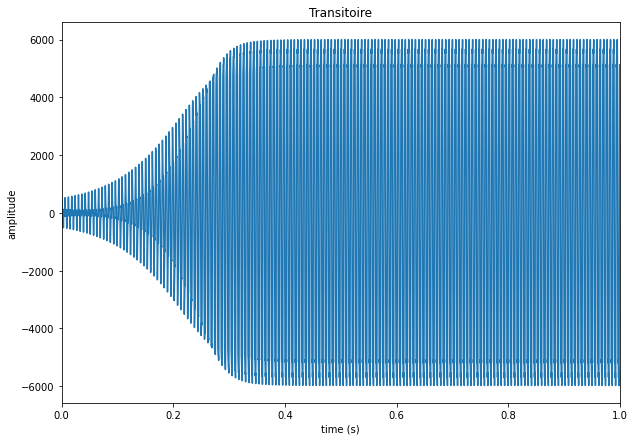

3modes


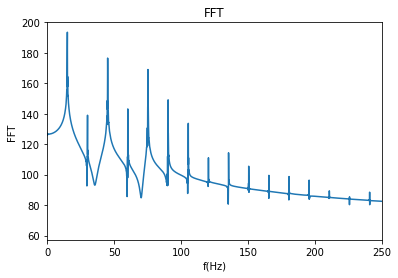

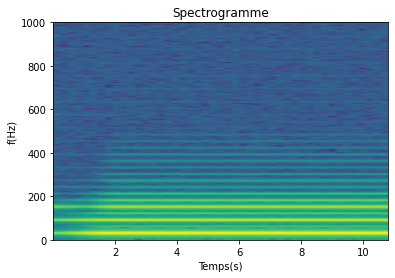

In [44]:
filename = "3modes"

t, X = get_signal_3_modes(gamma, zeta, DISPLAY=True)
len_sig, signal_synth = output_sound(X, end=1, name=filename)

plt.figure()
plt.plot(np.fft.fftfreq(len_sig)[:int(len_sig/2)]*Fs/2, 10*np.log(np.abs(np.fft.fft(signal_synth)))[:int(len_sig/2)])
plt.xlim([0, 250])
plt.xlabel("f(Hz)")
plt.ylabel("FFT")
plt.title("FFT")

plt.figure()
plt.specgram(np.array(signal_synth, dtype=np.int16), NFFT=2048, Fs=Fs)
plt.ylim([0,1000])
plt.xlabel("Temps(s)")
plt.ylabel("f(Hz)")
plt.title("Spectrogramme")

print(filename)
IPython.display.Audio(filename+".wav")